In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib
import torch

from files import RDMtask as rdm
from files import FullRankRNN as rnn
#from files import REINFORCE as rnf

In [2]:
importlib.reload(rdm)

task = rdm.PerceptualDecisionMaking()

In [3]:
importlib.reload(rnn)

input_size = 3
hidden_size = 128
output_size = 3

actor_network = rnn.FullRankRNN(input_size, hidden_size, output_size, 
                                noise_std=5e-2, alpha=0.2, rho=0.8, 
                                train_wi=True, train_wo=True)

input_size += hidden_size
hidden_size = 128
output_size = 1

critic_network = rnn.FullRankRNN(input_size, hidden_size, output_size, 
                                 noise_std=5e-2, alpha=0.2, rho=0.8, 
                                 train_wi=True, train_wo=True)

In [7]:
obs = []
actions = []
rewards = []
probs = []


n_tr = 50
trial_index = 1

store_trial_begin = np.zeros(n_tr)
time_step = 0
store_trial_begin[0] = time_step



In [8]:
task.new_trial()
action = 0

while trial_index <= n_tr:        
        
    ob, reward, done, info = task.step(action=action)
    action_probs = actor_network(ob)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    new_trial = info["new_trial"]

    obs.append(ob)
    rewards.append(reward)
    actions.append(action)
    probs.append(action_probs[action])

    if new_trial:
        
        if trial_index == n_tr:
            break
        
        store_trial_begin[trial_index] = time_step
        trial_index += 1
        
    time_step += 1

In [9]:
cum_rho = []

for i in range(n_tr):
    
    if i < n_tr-1:
        
        start = int(store_trial_begin[i])
        stop = int(store_trial_begin[i+1])
        trial_rewards = np.flip(np.array(rewards[start:stop]))
        cumulative_rewards = np.zeros(len(trial_rewards))
        cumulative_reward = 0
        
        for j in range(len(trial_rewards)):
            cumulative_reward +=  trial_rewards[j]
            cumulative_rewards[j] = cumulative_reward
        
        cum_rho.append(cumulative_rewards)
            
#print(trial_rewards)
#print(cumulative_rewards)


In [ ]:
log_probs = np.log(probs)
gradient_per_trial = 0
gradient_per_trial += log_probs[].backward() * cumulative_reward[n_and_t]


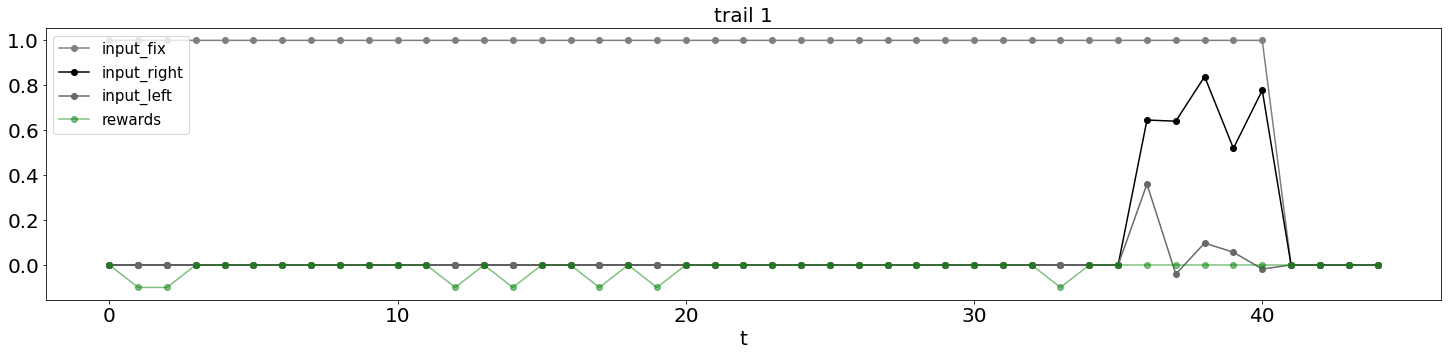

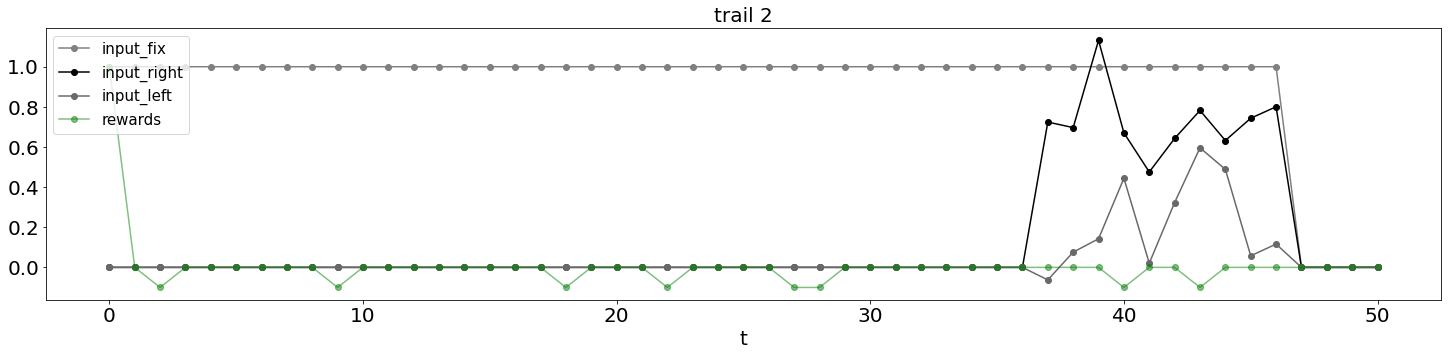

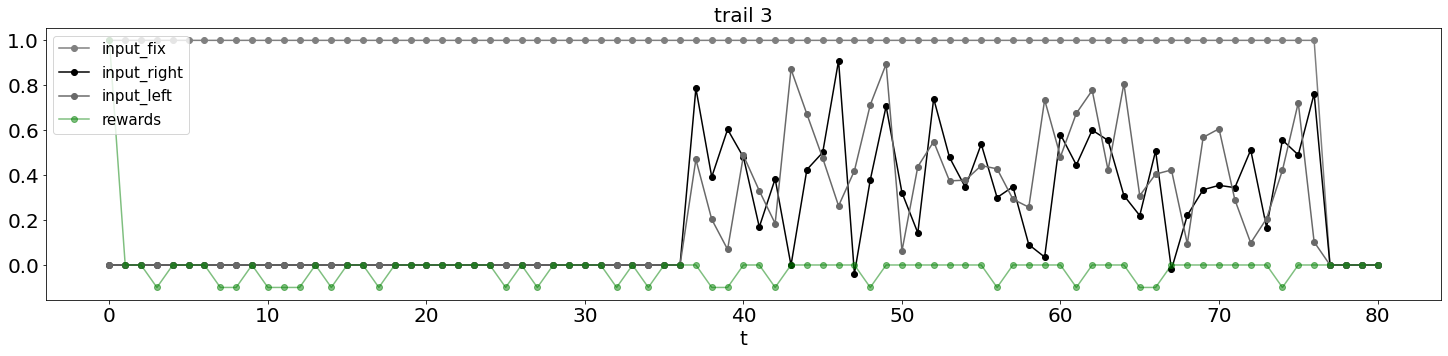

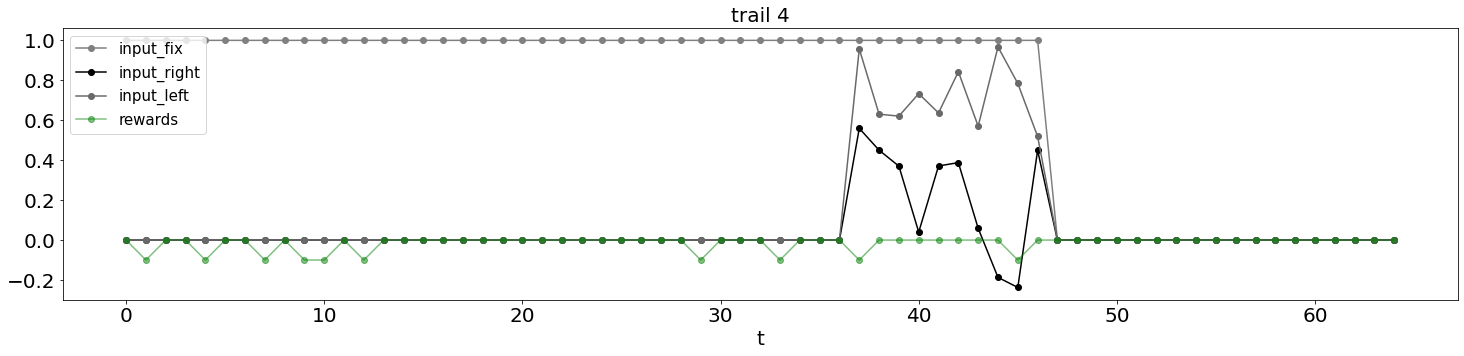

In [54]:
obs = np.asarray(obs)
obs = obs.T
#print(obs)

for i in range(n_tr-1):

    plt.figure(figsize=(25,5))
    
    start = int(store_trial_begin[i])
    stop = int(store_trial_begin[i+1])
    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="input_right", color="black")
    plt.plot(obs[2][start:stop], "-o", label="input_left", color="dimgray")
   # plt.plot(actions[start:stop], "-o", label="actions", color="red", alpha=0.5)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="green", alpha=0.5)
    
    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trail %i" %(i+1), size=20)
    plt.legend(fontsize=15, loc="upper left");